## 导库

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import accuracy_score,classification_report,roc_curve,auc,confusion_matrix,recall_score,roc_auc_score
from sklearn.model_selection import KFold,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import itertools
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from matplotlib.pyplot import figure
import seaborn as sns
import eli5
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 导入数据，**注意文件路径**

### 涉及多种采样方法以解决不平衡问题，还有很多自行百度，注意使用时注掉其他方法并更改重新建模处的采样方法

In [2]:
data = pd.read_csv(r"C:\Users\xuxt\Desktop\1.csv")
X = data.iloc[:,1:]    # X表示矩阵，从表文件csv的第二列开始，一直读取到最后一列
y = data.iloc[:,0]    # y表示向量，此处是表csv的第一列的列向量
X2 = StandardScaler().fit_transform(X)   # 将X矩阵标准化，记作X2
X_train, X_test, Y_train, Y_test = train_test_split(X2,y, test_size=0.3,random_state=10)

# from imblearn.over_sampling import RandomOverSampler         # 本案例采用 随机过采样
# ros = RandomOverSampler(random_state=0, sampling_strategy='auto')    
# X_train, Y_train = ros.fit_resample(X_train, Y_train)

# from imblearn.under_sampling import RandomUnderSampler     # 随机欠采样
# rus = RandomUnderSampler(random_state=0)
# X_train, Y_train = rus.fit_resample(X_train, Y_train)

# from imblearn.under_sampling import NearMiss               # 启发式选择样本，共3个version，更改即可不再重复说明
# nm1 = NearMiss(random_state=0, version=1)
# X_train, Y_train = nm1.fit_sample(X_train, Y_train)

# from imblearn.combine import SMOTEENN                      # 此为SMOTE+ENN结合方法(欠采样过采样结合法)
# smote_enn = SMOTEENN(random_state=0)
# X_train, Y_train = smote_enn.fit_resample(X_train, Y_train)

# from imblearn.combine import SMOTETomek                   # 此为SOMTE+Tomek结合方法(欠采样过采样结合法)
# smote_tomek = SMOTETomek(random_state=0)
# X_train, Y_train = smote_tomek.fit_resample(X_train, Y_train)

# from imblearn.over_sampling import BorderlineSMOTE        # 此为SMOTE Borderline-1 法
# sm = BorderlineSMOTE(random_state=42,kind="borderline-1") # (过采样，SMOTE为随即过采样的优化版，Borderline有1，2为SMOTE改良版)
# X_train, Y_train = sm.fit_resample(X_train, Y_train)

## 数据可视化

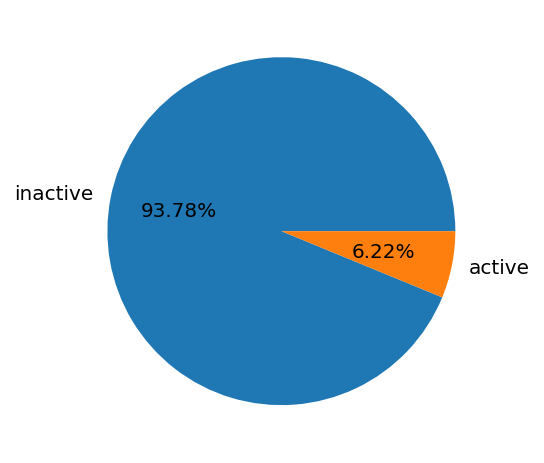

In [3]:
plt.axes(aspect='equal')
counts = y.value_counts() #统计LABEL中各类别的频数
plt.pie(x = counts, #绘制数据
        labels = pd.Series(counts.index).map({0:'inactive',1:'active'}),  #添加文字标签
        autopct='%.2f%%'    #设置百分比的格式，这里保留两位小数
        )
plt.show()     #该程序是为了统计数据集中带活性和非活性标签的数据各有多少
# plt.savefig('C:/Users/Administrator/Desktop/1.png', dpi=500, bbox_inches='tight')

## 数据不平衡预处理后的数据可视化

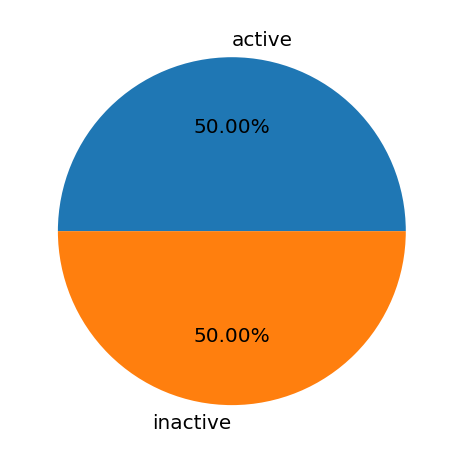

In [4]:
plt.axes(aspect='equal')
counts = Y_train.value_counts() #统计LABEL中各类别的频数
plt.pie(x = counts, #绘制数据
        labels = pd.Series(counts.index).map({0:'inactive',1:'active'}),  #添加文字标签
        autopct='%.2f%%'    #设置百分比的格式，这里保留两位小数
        )
plt.show()
# plt.savefig('C:/Users/Administrator/Desktop/2.png', dpi=500, bbox_inches='tight')

## 随机森林建模，第一行括号内为随机森林参数，**调参**

In [5]:
#随机森林分类
rfc = RandomForestClassifier(max_depth=2,
                             n_estimators=100,
                             random_state=5)   
rfc = rfc.fit(X_train, Y_train)
score_r = rfc.score(X_test,Y_test)
y_pred = rfc.predict(X_test)
y_score = rfc.predict_proba(X_test)[:,1]
y_pred_proba = rfc.predict_proba(X_test)

## 模型结果、评价以及混淆矩阵

模型的准确率为：
 0.8067504963600265
模型的评估报告：
               precision    recall  f1-score   support

           0       0.98      0.81      0.89      1411
           1       0.23      0.80      0.35       100

    accuracy                           0.81      1511
   macro avg       0.61      0.80      0.62      1511
weighted avg       0.93      0.81      0.85      1511



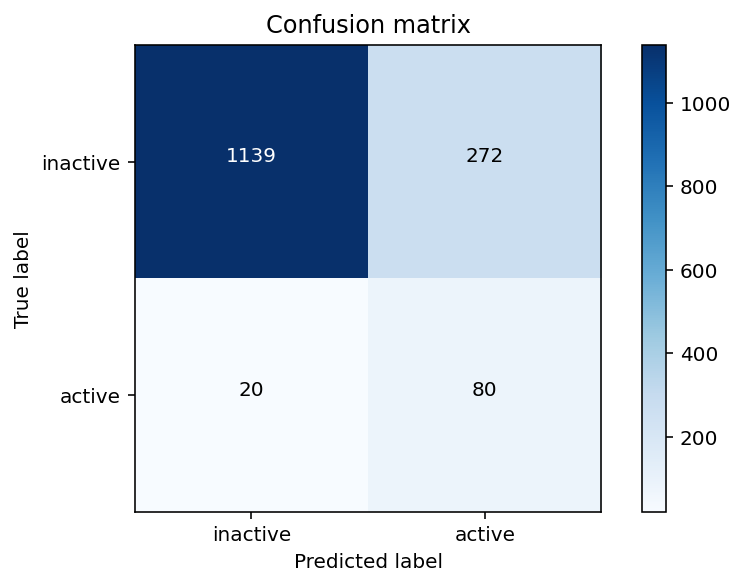

In [6]:
print('模型的准确率为：\n',accuracy_score(Y_test, y_pred))
print('模型的评估报告：\n',classification_report(Y_test, y_pred))
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):     #混淆矩阵，是表示精度评价的一种标准格式

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.savefig('C:/Users/Administrator/Desktop/3.png', dpi=500, bbox_inches='tight')
con = confusion_matrix(Y_test, y_pred)
plot_confusion_matrix(con, ['inactive','active'])

## ROC曲线、PR曲线

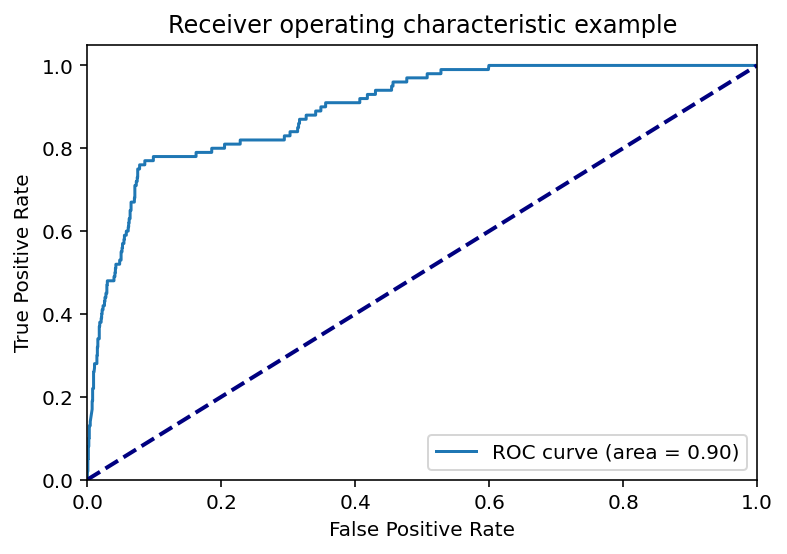

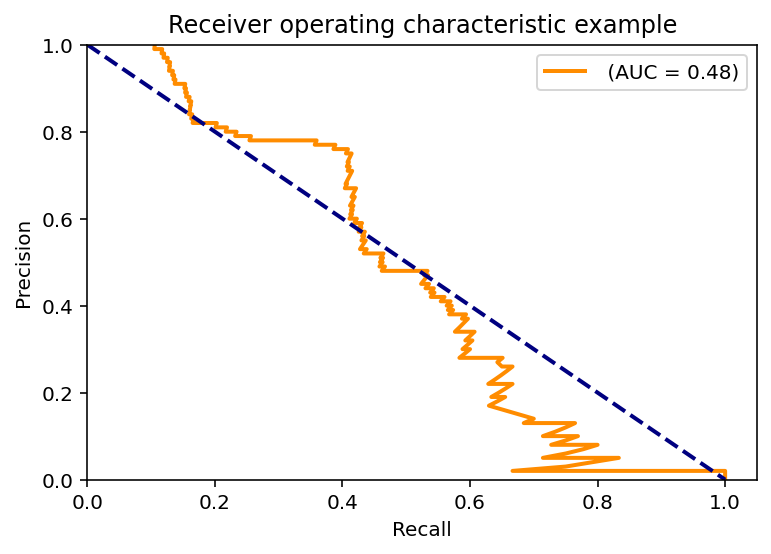

In [7]:
plt.figure()     #ROC曲线
fpr,tpr,threshold = roc_curve(Y_test, y_score)
roc_auc = auc(fpr,tpr)
lw = 2
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
# plt.savefig('C:/Users/Administrator/Desktop/4.png', dpi=500, bbox_inches='tight')

plt.figure()      #PR曲线
precision, recall, _thresholds = metrics.precision_recall_curve(Y_test, y_score)
prauc = metrics.auc(recall, precision)
plt.plot(precision, recall, color='darkorange',
        lw=lw, label=' (AUC = %0.2f)' % prauc)
plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Receiver operating characteristic example')
plt.legend(loc="upper right")
plt.show()
# plt.savefig('C:/Users/Administrator/Desktop/5.png', dpi=500, bbox_inches='tight')

## 评价指标——KS值

In [8]:
ks_value = max(abs(fpr-tpr))
ks_value

0.6842452161587527

## 模型特征变量权重可视化

In [9]:
X_train = pd.DataFrame(X_train)     #模型的描述符及权重
Y_train = pd.DataFrame(Y_train)
X_test = pd.DataFrame(X_test)
Y_test = pd.DataFrame(Y_test)
ColNames = X.columns
ColNames_List = X.columns.tolist()
print(ColNames,type(ColNames))
X_train.columns = [ColNames_List]
X_test.columns = [ColNames_List]
feature_names = X_train.columns
feature_importances = rfc.feature_importances_
indices = np.argsort(feature_importances)[::-1]
for index in indices:
    print("feature %s (%f)" %(feature_names[index], feature_importances[index]))
eli5.show_weights(rfc, feature_names=X.columns.to_list())

Index(['LogKow', 'A', 'B', 'Bo', 'E', 'L', 'S', 'V', 'AAB/LogP',
       'Abraham's Alfa', 'Abraham's BetaH', 'LogL', 'Pi2', 'R2', 'MW',
       'McGowan Volume', 'Ertl TPSA', 'Sw < 0.1 mg/ml probability',
       'Sw > 10 mg/ml probability', 'Sw < 1 mg/ml probability', 'LogS(pH=7)',
       'LogSw', 'LogSwLo', 'LogSwHi', 'Acid_pKa', 'Base_pKa', '#NAME?',
       '#NAME?.1', '盕orm', '0Form', 'LogD(pH=7)', 'NoOfRotBonds', 'Rule of 5',
       'No Of H Donors', 'No Of H Acceptors'],
      dtype='object') <class 'pandas.core.indexes.base.Index'>
feature ('LogS(pH=7)',) (0.261572)
feature ('R2',) (0.102437)
feature ('E',) (0.094549)
feature ('S',) (0.074677)
feature ('Ertl TPSA',) (0.057143)
feature ('L',) (0.055147)
feature ('MW',) (0.054607)
feature ('Pi2',) (0.052229)
feature ('LogL',) (0.049291)
feature ('LogSwLo',) (0.034736)
feature ('Sw < 1 mg/ml probability',) (0.026313)
feature ('LogSw',) (0.026122)
feature ('LogD(pH=7)',) (0.020855)
feature ('AAB/LogP',) (0.017070)
feature ('McGowan Vo

Weight,Feature
0.2616 ± 0.6900,LogS(pH=7)
0.1024 ± 0.4746,R2
0.0945 ± 0.4375,E
0.0747 ± 0.3870,S
0.0571 ± 0.2885,Ertl TPSA
0.0551 ± 0.3489,L
0.0546 ± 0.3491,MW
0.0522 ± 0.2925,Pi2
0.0493 ± 0.3190,LogL
0.0347 ± 0.2207,LogSwLo


## 自变量关于因变量的相关性

In [10]:
Numeric_df = pd.DataFrame(X)
Numeric_df['Y'] = y
corr= Numeric_df.corr()
corr_y = abs(corr["Y"])
highest_corr = corr_y[corr_y >0.05]
highest_corr.sort_values(ascending=True)

Rule of 5                     0.052749
No Of H Donors                0.052929
AAB/LogP                      0.054598
LogD(pH=7)                    0.060987
A                             0.067584
Abraham's Alfa                0.073424
Abraham's BetaH               0.077328
Acid_pKa                      0.080542
Sw > 10 mg/ml probability     0.084712
Sw < 0.1 mg/ml probability    0.095029
B                             0.107501
Bo                            0.107890
Sw < 1 mg/ml probability      0.109576
Ertl TPSA                     0.122626
No Of H Acceptors             0.123330
McGowan Volume                0.126914
V                             0.126914
LogSw                         0.133705
S                             0.151591
L                             0.160066
Pi2                           0.161447
LogL                          0.167083
MW                            0.167758
R2                            0.189893
E                             0.200217
LogS(pH=7)               

## 选择模型认为重要的变量重新建模，**首行更改变量名称**

In [11]:
X_Reduced = X[['LogS(pH=7)','R2', 'E','S','Ertl TPSA','L','MW']]
X_Reduced = StandardScaler().fit_transform(X_Reduced)
X_Train2, X_Test2, Y_Train2, Y_Test2 = train_test_split(X_Reduced, y, test_size = 0.30, random_state = 10)
X_Train2, Y_Train2 = ros.fit_resample(X_Train2, Y_Train2)
X_Train2 = pd.DataFrame(X_Train2)
Y_Train2 = pd.DataFrame(Y_Train2)

trainedforest = RandomForestClassifier(max_depth=5, n_estimators=100,random_state=5).fit(X_Train2,Y_Train2)

predictionforest = trainedforest.predict(X_Test2)
print(confusion_matrix(Y_Test2,predictionforest))
print(classification_report(Y_Test2,predictionforest))     #筛选主要描述符，看模型性能

[[1237  174]
 [  13   87]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1411
           1       0.33      0.87      0.48       100

    accuracy                           0.88      1511
   macro avg       0.66      0.87      0.71      1511
weighted avg       0.95      0.88      0.90      1511



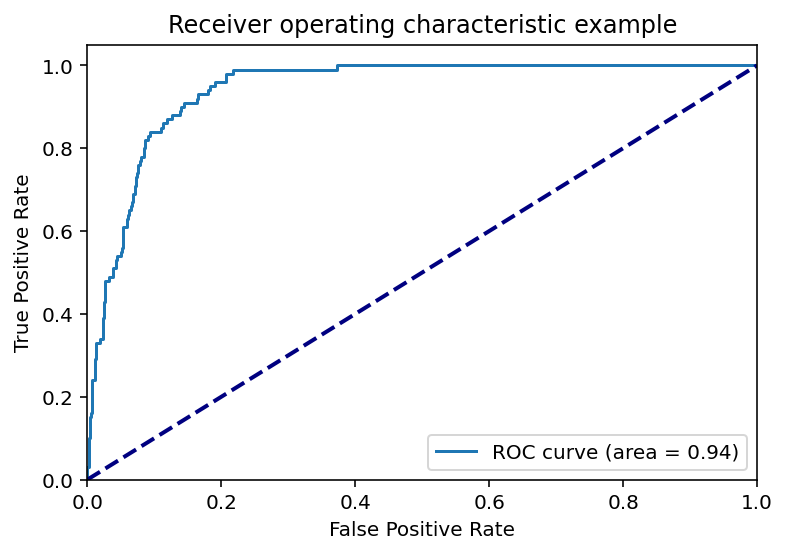

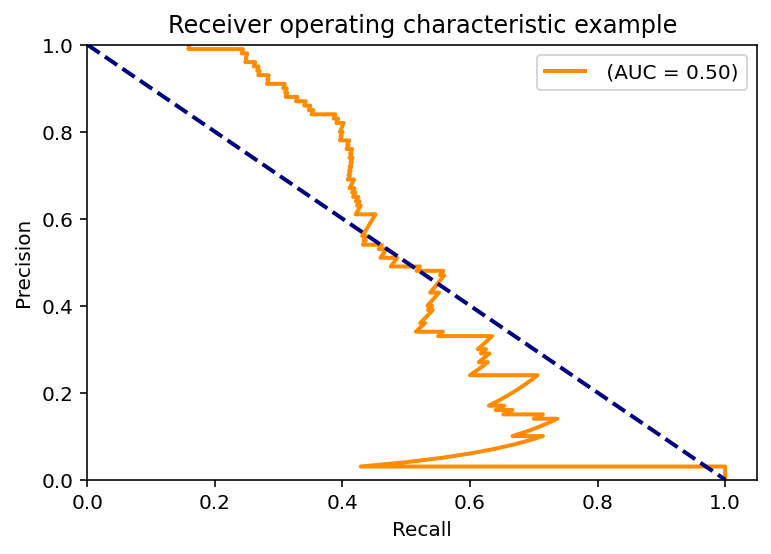

In [12]:
ypredictionforest = trainedforest.predict_proba(X_Test2)[:,1]
plt.figure()
fpr,tpr,threshold = roc_curve(Y_Test2, ypredictionforest)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
# plt.savefig('C:/Users/Administrator/Desktop/6.png', dpi=500, bbox_inches='tight')


plt.figure()
precision, recall, _thresholds = metrics.precision_recall_curve(Y_Test2, ypredictionforest)
prauc = metrics.auc(recall, precision)
plt.plot(precision, recall, color='darkorange',
        lw=lw, label=' (AUC = %0.2f)' % prauc)
plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Receiver operating characteristic example')
plt.legend(loc="upper right")
plt.show()
# plt.savefig('C:/Users/Administrator/Desktop/7.png', dpi=500, bbox_inches='tight')

## 变量间相关性热力图——皮尔逊相关

[Text(0, 0.5, 'LogS(pH=7)'),
 Text(0, 1.5, 'R2'),
 Text(0, 2.5, 'E'),
 Text(0, 3.5, 'S'),
 Text(0, 4.5, 'Ertl TPSA'),
 Text(0, 5.5, 'L'),
 Text(0, 6.5, 'MW')]

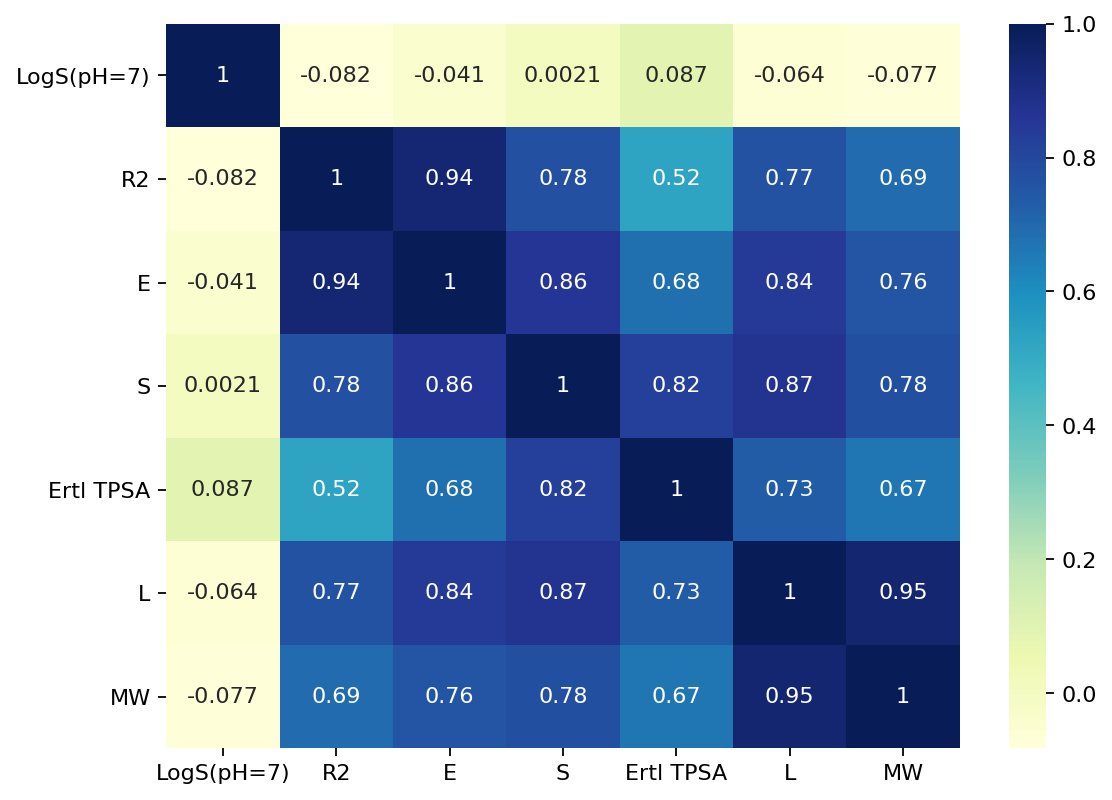

In [13]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

corr2 = Numeric_df[['LogS(pH=7)','R2', 'E','S','Ertl TPSA','L','MW']].corr()     #进行相关性分析

g = sns.heatmap(corr2, cmap='YlGnBu', annot=True, fmt=".2g")
g.set_yticklabels(g.get_yticklabels(),rotation=360)
# plt.xticks(rotation=45)       # 可以旋转横坐标名称

## 评价指标——KS值

In [14]:
ks_value = max(abs(fpr-tpr))
ks_value

0.7724238128986534

# 逻辑回归建模

In [15]:
lr = LogisticRegression(C = 1,
                        penalty = 'l2')   #该程序是进行LogisticRegression分析
lr.fit(X_train,Y_train.values.ravel())
y_pred = lr.predict_proba(X_test)

## 模型结果、评价以及混淆矩阵

模型的准确率为：
 0.8391793514228988
模型的评估报告：
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1411
           1       0.27      0.82      0.40       100

    accuracy                           0.84      1511
   macro avg       0.63      0.83      0.66      1511
weighted avg       0.94      0.84      0.87      1511



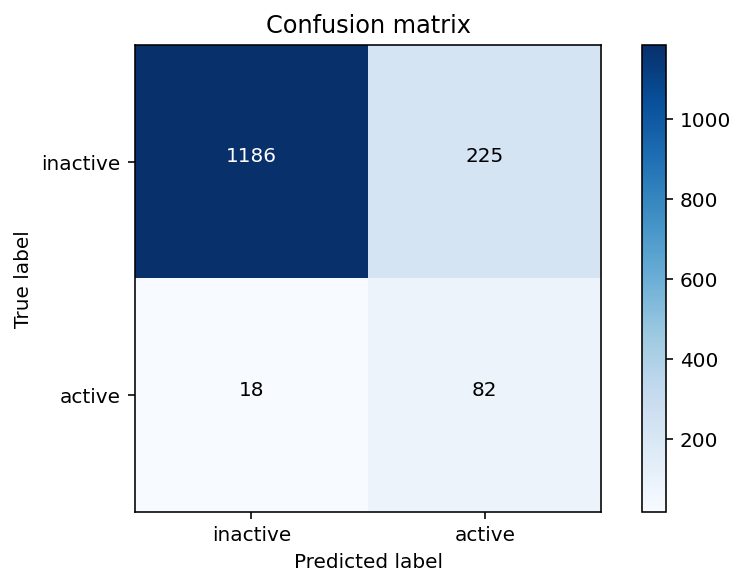

In [16]:
print('模型的准确率为：\n',accuracy_score(Y_test, lr.predict(X_test)))
print('模型的评估报告：\n',classification_report(Y_test, lr.predict(X_test)))
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.savefig('C:/Users/Administrator/Desktop/6.png', dpi=500, bbox_inches='tight')
con = confusion_matrix(Y_test, lr.predict(X_test))
plot_confusion_matrix(con, ['inactive','active'])

## ROC曲线、PR曲线

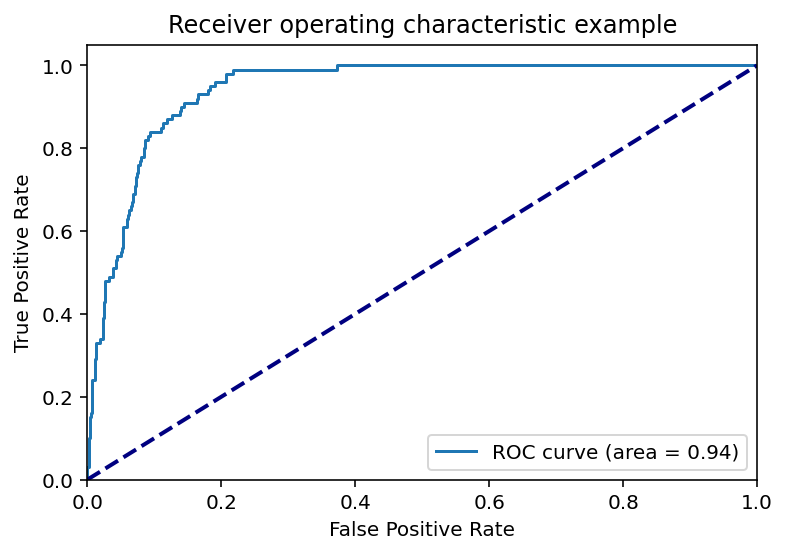

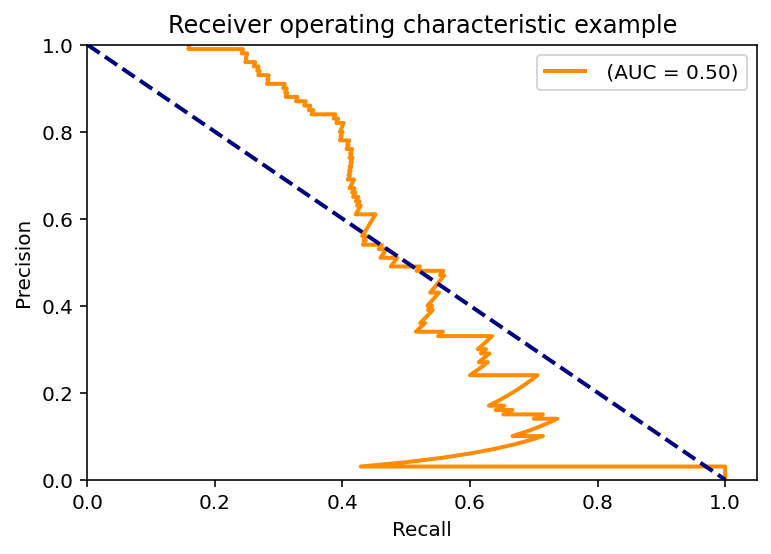

In [17]:
ypredictionforest = trainedforest.predict_proba(X_Test2)[:,1]

plt.figure()
fpr,tpr,threshold = roc_curve(Y_Test2, ypredictionforest)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
# plt.savefig('C:/Users/xuchen/Desktop/7.png', dpi=500, bbox_inches='tight')

plt.figure()
precision, recall, _thresholds = metrics.precision_recall_curve(Y_Test2, ypredictionforest)
prauc = metrics.auc(recall, precision)
plt.plot(precision, recall, color='darkorange',
        lw=lw, label=' (AUC = %0.2f)' % prauc)
plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Receiver operating characteristic example')
plt.legend(loc="upper right")
plt.show()
# plt.savefig('C:/Users/xuchen/Desktop/8.png', dpi=500, bbox_inches='tight')

## 选择自己想解释的变量且这些变量绝对不可以出现排除共线性问题

In [ ]:
X_Reduced = X[['']] # 填入变量名称
X_Reduced = StandardScaler().fit_transform(X_Reduced)
X_Train2, X_Test2, Y_Train2, Y_Test2 = train_test_split(X_Reduced, y, test_size = 0.30, random_state = 10)
ros = RandomOverSampler(random_state=0, sampling_strategy='auto') 
X_Train2, Y_Train2 = ros.fit_sample(X_Train2, Y_Train2)
X_Train2 = pd.DataFrame(X_Train2)
Y_Train2 = pd.DataFrame(Y_Train2)

trainedforest = LogisticRegression(C = 1, penalty = 'l2').fit(X_Train2,Y_Train2)

predictionforest = trainedforest.predict(X_Test2)

## 结果、评价及混淆矩阵

In [ ]:
print(confusion_matrix(Y_Test2,predictionforest))
print(classification_report(Y_Test2,predictionforest))
con = confusion_matrix(Y_Test2, predictionforest)
plot_confusion_matrix(con, ['inactive','active'])

## 逻辑回归的自变量系数及截距

In [ ]:
trainedforest.coef_

In [ ]:
trainedforest.intercept_

In [ ]:
y_score = trainedforest.predict_proba(X_Test2)[:,1]

plt.figure()
fpr,tpr,threshold = roc_curve(Y_Test2, y_score)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
# plt.savefig('C:/Users/xuchen/Desktop/9.png', dpi=500, bbox_inches='tight')